**Model Pipeline Mujoco Cable**

Install libraries

In [2]:
import torch
from torch import nn
import numpy as np
import time
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import random
import wandb
from scipy.optimize import minimize
from tqdm import tqdm
import json

In [ ]:
# Load data and concatenate
file_paths = [
    'simulation_data_auto_2D_5000_new_4e6_01.npz',
    'simulation_data_auto_2D_5000_new_4e6_02.npz',
    'simulation_data_auto_2D_5000_new_4e6_03.npz',
    'simulation_data_auto_2D_5000_new_4e6_04.npz',
    'simulation_data_auto_2D_5000_new_4e6_05.npz',
    'simulation_data_auto_2D_5000_new_4e6_06.npz',
    'simulation_data_auto_2D_5000_new_4e6_07.npz',
    'simulation_data_auto_2D_5000_new_4e6_08.npz',
    'simulation_data_auto_2D_5000_new_2e6_01.npz',
    'simulation_data_auto_2D_5000_new_2e6_02.npz',
    # ...
]

data_list = [np.load(fp) for fp in file_paths]

combined_time = np.concatenate([d['time'] for d in data_list], axis=0)
combined_EE_pos = np.concatenate([d['EE_pos'] for d in data_list], axis=0)
combined_EE_vel = np.concatenate([d['EE_vel'] for d in data_list], axis=0)
combined_cable_pos = np.concatenate([d['cable_pos'] for d in data_list], axis=0)

np.savez_compressed('combined_dataset_NEW_METHOD_50k.npz',
                    time=combined_time,
                    EE_pos=combined_EE_pos,
                    EE_vel=combined_EE_vel,
                    cable_pos=combined_cable_pos)

In [11]:
file_path = '/home/lukas-zeh/Documents/GNN_CableSimulation/simulationData/data/simulation_data_20K_no_reset.npz'

In [4]:
# Load data and preprocess
class SimulationDataset(data_utils.Dataset):
    def __init__(self, file_path):

        data = np.load(file_path)
        self.EE_pos = torch.tensor(data['EE_pos'][:, [0, 1, 2, 4]], dtype=torch.float32)  # Shape: (_, 4)
        self.EE_vel = torch.tensor(data['EE_vel'][:, [0, 1, 2, 5]], dtype=torch.float32) * 0.02 # Shape: (_, 4)
        self.cable_pos = torch.tensor(data['cable_pos'], dtype=torch.float32)  # Shape: (_, 50, 3)
        self.cable_pos_noise = torch.tensor(data['cable_pos'], dtype=torch.float32)  # Shape: (_, 50, 3)
        self.add_noise(std_EE=0, std_vel=0, std_cable=0.001)
        self.relativ_cable_pos = self.precompute_relative_positions_tEE()


        # get velocity from noise data
        self.cable_vel = torch.diff(self.cable_pos_noise, dim=0)

        # Normalizing
        self.EE_pos_mean = self.EE_pos.mean(dim=0)
        self.EE_pos_std = self.EE_pos.std(dim=0)
        self.EE_vel_mean = self.EE_vel.mean(dim=0)  # Shape: (D,)
        self.EE_vel_std = self.EE_vel.std(dim=0)    # Shape: (D,)
        self.l2_relativ_norm_cable_pos = torch.norm(self.relativ_cable_pos, dim=2, keepdim=True)
        self.cable_vel_mean = self.cable_vel.mean(dim=(0, 1), keepdim=True)
        self.cable_vel_std = self.cable_vel.std(dim=(0, 1), keepdim=True)
        eps = 1e-9

        # Normalizing
        self.EE_pos_normalized = (self.EE_pos - self.EE_pos_mean) / (self.EE_pos_std + eps)
        self.EE_vel_normalized = (self.EE_vel - self.EE_vel_mean) / (self.EE_vel_std + eps)
        self.cable_pos_normalized = self.relativ_cable_pos / (self.l2_relativ_norm_cable_pos + eps)
        self.cable_vel_normalized = (self.cable_vel - self.cable_vel_mean) / (self.cable_vel_std + eps)

        stats = {
            "EE_vel_mean": self.EE_vel_mean.tolist(),
            "EE_vel_std": self.EE_vel_std.tolist(),
            "cable_vel_mean": self.cable_vel_mean.tolist(),
            "cable_vel_std": self.cable_vel_std.tolist()
        }
        with open("normalization_stats.json", "w") as f:
            json.dump(stats, f, indent=4)

        self.num_markers = 9

        # Debug
        print("EE_pos normalized Shape", self.EE_pos_normalized.shape)  # Shape: (_, 4)
        print("EE_vel normalized Shape", self.EE_vel_normalized.shape)  # Shape: (_, 4)
        print("cable_pos normalized Shape", self.cable_pos_normalized.shape)  # Shape: (_, 50, 3)

    def precompute_relative_positions(self):
            T = self.cable_pos_noise.shape[0]
            all_rel_positions = []

            for t in range(T):
                coords = self.cable_pos_noise[t, :, :2]
                coords = coords[6:-3]
                coords = coords[::5]

                relative_DLO = coords[1:] - coords[:-1]

                EE_pos = self.EE_pos[t, :2]
                first_marker_relative_to_EE = coords[0] - EE_pos.unsqueeze(0)

                rel_coords_t = torch.cat((first_marker_relative_to_EE, relative_DLO), dim=0)
                all_rel_positions.append(rel_coords_t)


            precomputed_rel_positions = torch.stack(all_rel_positions, dim=0)
            return precomputed_rel_positions

    def precompute_relative_positions_tEE(self):
        T = self.cable_pos_noise.shape[0]
        all_rel_positions = []

        for t in range(T):
            coords = self.cable_pos_noise[t, :, :2]
            coords = coords[6:-3]
            coords = coords[::5]
            EE_pos = self.EE_pos[t, :2]
            rel_positions = coords - EE_pos.unsqueeze(0)

            all_rel_positions.append(rel_positions)

        precomputed_rel_positions = torch.stack(all_rel_positions, dim=0)
        return precomputed_rel_positions

    def get_local_relativ_positions(self, idx):

        coords = self.cable_pos_noise[idx, :, :2]  # x y
        coords = coords[6:-3]
        coords = coords[::5]

        relative_DLO = coords[1:] - coords[:-1]
        EE_pos = self.EE_pos[idx, :2]
        first_marker_relative_to_EE = coords[0] - EE_pos.unsqueeze(0)
        relative_DLO = torch.cat((first_marker_relative_to_EE, relative_DLO), dim=0)

        return relative_DLO


    def add_noise(self, std_EE=0.001, std_vel=0.001, std_cable=0.002):
        noise_EE = torch.normal(0, std_EE, size=self.EE_pos.shape)
        noise_vel = torch.normal(0, std_vel, size=self.EE_vel.shape)
        noise_cable = torch.normal(0, std_cable, size=self.cable_pos.shape)

        self.EE_pos += noise_EE
        self.EE_vel += noise_vel
        self.cable_pos_noise += noise_cable

    def get_norm_absolute_coords(self, idx):
        absolute_coords = self.cable_pos_normalized[idx, :, :2]
        absolute_coords = absolute_coords[6:-3]
        absolute_coords = absolute_coords[::5]

        return absolute_coords.flatten()

    def get_absolute_coords(self, idx):
        absolute_coords = self.cable_pos[idx, :, :2]
        absolute_coords = absolute_coords[6:-3]
        absolute_coords = absolute_coords[::5]

        return absolute_coords.flatten()

    def get_norm_marker_velocity(self, idx):
        if idx == 0:

            return torch.zeros(self.num_markers, 2)

        norm_velocity = self.cable_vel_normalized[idx, :, :2]
        norm_velocity = norm_velocity[6:-3]
        norm_velocity = norm_velocity[::5]

        return norm_velocity


    def __len__(self):
        return len(self.EE_pos) - 2

    def __getitem__(self, idx):
        current_robot_state_pos = self.EE_pos_normalized[idx].unsqueeze(0)  # Shape: (1, 4)
        current_robot_state_vel = self.EE_vel_normalized[idx].unsqueeze(0)  # Shape: (1, 4)
        current_robot_state = torch.cat((current_robot_state_pos, current_robot_state_vel), dim=1)  # Shape: (1, 8)

        current_relative_dlo_state = self.cable_pos_normalized[idx]  # Shape: (9, 2)
        if idx > 0:
            current_relative_dlo_velocity = self.get_norm_marker_velocity(idx - 1)  # Shape: (9, 2)
        else:
            current_relative_dlo_velocity = torch.zeros(self.num_markers, 2)  # Shape: (9, 2)

        current_dlo_state = torch.cat((current_relative_dlo_state, current_relative_dlo_velocity), dim=1)  # Shape: (9, 4)

        # Repeat robot state for each marker
        repeated_robot_state = current_robot_state.repeat(self.num_markers, 1)  # Shape: (9, 8)

        # Combine robot state and DLO state
        inputs = torch.cat((repeated_robot_state, current_dlo_state), dim=1)  # Shape: (9, 12)
        inputs = inputs.reshape(-1)  # Flatten inputs
        
        target = self.get_norm_marker_velocity(idx).reshape(-1)  # Shape: (num_markers * 2,)

        return inputs, target

In [5]:
#check for gpu
if torch.cuda.is_available():
   device = torch.device("cuda")
   x = torch.ones(1, device=device)
   print (x)
else:
   device = torch.device("cpu")
   print ("Cuda device not found.")

tensor([1.], device='cuda:0')


In [12]:
dataset = SimulationDataset(file_path)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_indices = range(0, train_size)
val_indices = range(train_size, len(dataset))

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")

EE_pos normalized Shape torch.Size([6000576, 4])
EE_vel normalized Shape torch.Size([6000576, 4])
cable_pos normalized Shape torch.Size([6000576, 9, 2])
Train size: 4800459, Validation size: 1200115


In [13]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
# Initialize Model, Loss, and Optimizer
input_size = 108  # qpos and qvel
output_size = 18  # xpos dimension
model = MLPModel(input_size, output_size, hidden_size=128)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))
# Training Loop
epochs = 50
train_losses = []
val_losses = []
model.to(device)

MLPModel(
  (fc1): Linear(in_features=108, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=18, bias=True)
  (relu): ReLU()
)

In [ ]:
# Initialize best validation loss before training loop
best_val_loss = float('inf')

for epoch in tqdm(range(epochs), desc="Epochs"):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=True)
    for inputs, targets in train_loader_tqdm:

        inputs = inputs.float().to(device)
        targets = targets.float().to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation Loop
    model.eval()
    val_loss = 0.0
    val_loader_tqdm = tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", leave=True)
    with torch.no_grad():
        for inputs, targets in val_loader_tqdm:
            inputs = inputs.float().to(device)
            targets = targets.float().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Save the best model when validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '2D_mlp_model_20k_no_reset_best.pth')
        print(f'Best model saved with validation loss: {val_loss:.4e}')

    #Reduce Learning Rate
    scheduler.step()

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4e}, Val Loss: {val_loss:.4e}')
    
# Save the final trained model
torch.save(model.state_dict(), '2D_mlp_model_20k_no_reset.pth')


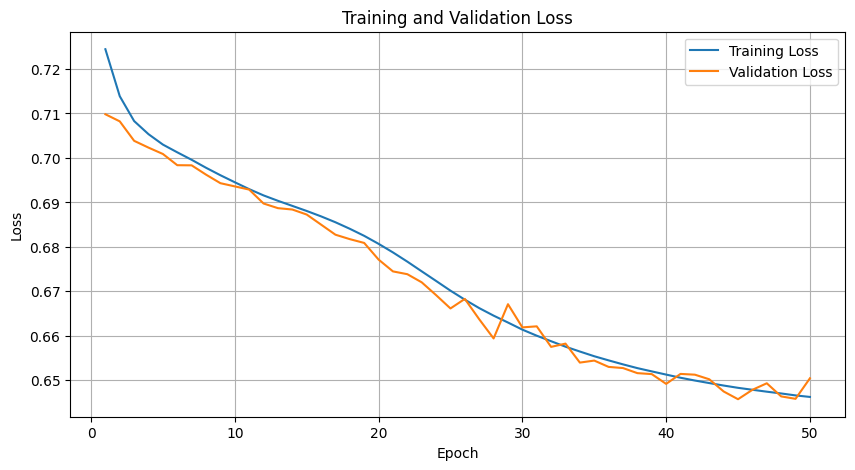

In [21]:
train_losses = train_losses[:epochs]
val_losses = val_losses[:epochs]

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
def velocity_error(groundtruth_vel, predicted_vel):
    numerator = np.linalg.norm(groundtruth_vel - predicted_vel, ord=2)
    denominator = np.linalg.norm(groundtruth_vel, ord=2)
    e_vel = (numerator / denominator) * 100

    return e_vel

In [9]:
file_path = 'simulationData/data/simulation_data_rollout.npz'
dataset = SimulationDataset(file_path)

FileNotFoundError: [Errno 2] No such file or directory: 'simulationData/data/simulation_data_rollout.npz'

## Use this with wandb model checkpoints .pt files

In [18]:
# Load the checkpoint
checkpoint = torch.load("models/MLP_best_h128_l3_lr0.0001_bs256_20K.pt", map_location=device)

# Create a new state dict with renamed keys
if "model_state_dict" in checkpoint:
    state_dict = checkpoint["model_state_dict"]
    new_state_dict = {}
    
    # Map from saved model keys to your current model keys
    key_mapping = {
        "layers.0.weight": "fc1.weight", "layers.0.bias": "fc1.bias",
        "layers.1.weight": "fc2.weight", "layers.1.bias": "fc2.bias",
        "layers.2.weight": "fc3.weight", "layers.2.bias": "fc3.bias"
    }
    
    for old_key, new_key in key_mapping.items():
        if old_key in state_dict:
            new_state_dict[new_key] = state_dict[old_key]
    
    # Load the renamed state dict
    model.load_state_dict(new_state_dict)
    print("Model loaded successfully with renamed keys")
else:
    print("Error: checkpoint doesn't contain expected model_state_dict")

Model loaded successfully with renamed keys


/tmp/ipykernel_3867130/3027066028.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("models/MLP_best_h128_l3_lr0.0001_bs256_20K.pt", map_location=d

## Else use this with state dicts

KeyboardInterrupt: 

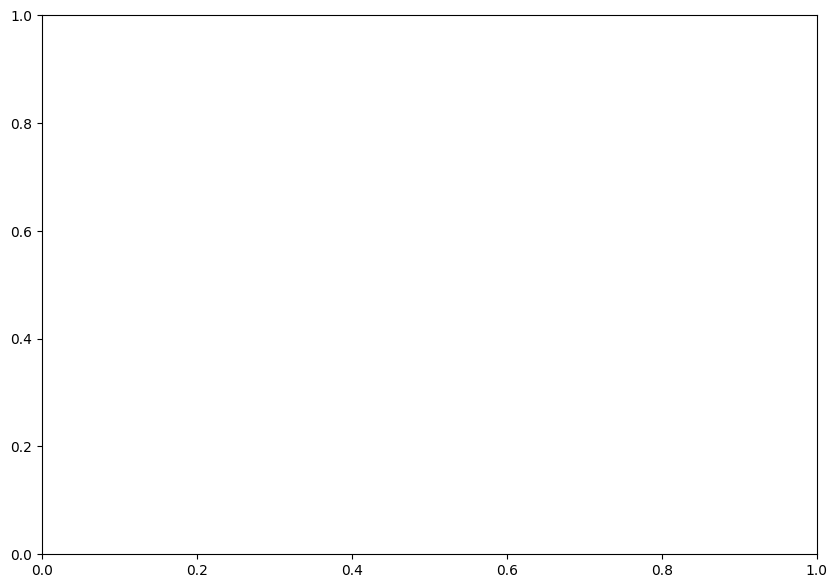

In [19]:
#model.load_state_dict(torch.load("models/MLP_best_h128_l3_lr0.0001_bs256_20K.pt", weights_only=True, map_location=device))
device = 'cpu'
model.to(device)  # Move the model to the device
model.eval()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

start_idx = 50
step = 5
end_idx = len(dataset) - 250
velocity_error_list = []
shape_error_list = []
max_error_list = []
min_error_list = []

for idx in range(start_idx, end_idx, step):

        inputs, targets = dataset[idx]
        # Add batch dimension to inputs
        inputs = inputs.unsqueeze(0)
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        with torch.no_grad():
                # Generate predictions
                outputs = model(inputs)

                predictions = outputs.view(-1, 2).cpu()
                targets = targets.view(-1, 2).cpu()

                EE_pos_x, EE_pos_y = dataset.EE_pos_normalized[idx, :2]
                basis_position = torch.tensor([EE_pos_x, EE_pos_y], device=device)

                cable_vel_mean = torch.tensor([-7.6191895e-08,  5.4330588e-08], device=device)
                cable_vel_std = torch.tensor([0.007593654096126556, 0.006266195327043533], device=device)

                prediction_entnorm = predictions * cable_vel_std + cable_vel_mean
                target_entnorm = targets * cable_vel_std + cable_vel_mean
                velocity_error_prediction = velocity_error(target_entnorm, prediction_entnorm)
                velocity_error_list.append(velocity_error_prediction)
                pred_abs = dataset.get_absolute_coords(idx).view(9, 2) + prediction_entnorm
                target_abs = dataset.get_absolute_coords(idx).view(9, 2) + target_entnorm
                e_shape = torch.norm(pred_abs - target_abs, p=2)
                max_error = (pred_abs - target_abs).norm(dim=1).max()
                min_error = (pred_abs - target_abs).norm(dim=1).min()
                max_error_list.append(max_error)
                min_error_list.append(min_error)

                shape_error_list.append(e_shape)

max_error_mean = np.max(max_error_list)
print('Max Error in m: ', max_error_mean)

min_error_mean = np.min(min_error_list)
print('Min Error in m: ', min_error_mean)
if velocity_error_list:
    vel_error_mean = np.mean(velocity_error_list)
    print(f"Mean Velocity Error in %: {vel_error_mean}")


if shape_error_list:
    shape_error_mean = np.mean(shape_error_list)
    print(f"Mean Shape Error in m: {shape_error_mean}")

# Plot predictions
ax.scatter(pred_abs[:, 0].numpy(), pred_abs[:, 1].numpy(),
        label='Predicted Cable Shape', linestyle='dashed', color='red')

# Plot actual cable shape
ax.scatter(target_abs[:, 0].numpy(), target_abs[:, 1].numpy(),
        label='Actual Cable Shape', linestyle='dashed', color='blue')

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_xlim([-0.3, 1])
#ax.set_ylim([0, 0.3])
ax.set_title('Predicted vs Actual Cable Shape')
ax.legend()
plt.show()


In [ ]:
dataset = SimulationDataset('data/simulation_data_rollout.npz')

In [15]:
model.eval()
model.to(device)

MLPModel(
  (fc1): Linear(in_features=108, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=18, bias=True)
  (relu): ReLU()
)

velocity_error_list [np.float64(155.2197450176247), np.float32(86.53571), np.float32(115.67608), np.float32(173.03401), np.float32(299.23376)]
shape_error_list [tensor(0.0293), tensor(0.0242), tensor(0.0253), tensor(0.0364), tensor(0.0509)]


/tmp/ipykernel_3867130/153470948.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cable_vel_std = torch.tensor(cable_vel_std, device=device).unsqueeze(0).repeat(1, 9)
/tmp/ipykernel_3867130/153470948.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cable_vel_mean = torch.tensor(cable_vel_mean, device=device).unsqueeze(0).repeat(1, 9)
/tmp/ipykernel_3867130/153470948.py:131: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


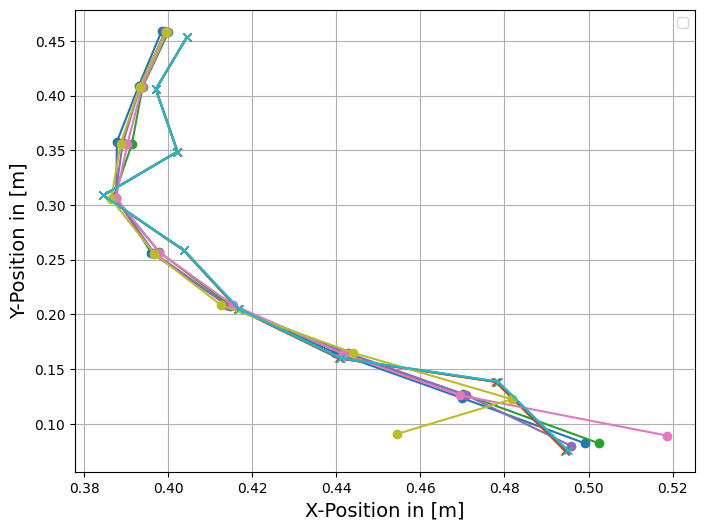

In [23]:
def get_local_relativ_positions(idx, coords, normalize=False):

        EE_pos = dataset.EE_pos[idx, :2]
        rel_positions = coords - EE_pos.unsqueeze(0)  # (9, 2)


        if normalize:
            l2_norm = torch.norm(rel_positions, dim=1, keepdim=True)
            l2_norm[l2_norm == 0] = 1e-9 # Avoid division by zero
            rel_positions = rel_positions / l2_norm

        return rel_positions


def rollout_velocity_mlp(model, dataset, rollout_steps=5, device=torch.device('cpu' if torch.cuda.is_available() else 'cpu')):
    max_idx = len(dataset) - 1 - rollout_steps
    random_idx = 200
    inputs, targets = dataset[random_idx]
    model.eval()
    model.to(device)

    coords = dataset.cable_pos[random_idx, :, :2]
    coords = coords[6:-3]
    new_abs_position = coords[::5]
    trajectories = []
    ground_truth_list = []
    EE_Pos_list = []
    velocity_error_list = []
    shape_error_list = []

    cable_vel_mean = np.array([-7.6191895e-08, 5.4330588e-08])
    cable_vel_std = np.array([0.007593654096126556, 0.006266195327043533])

    for step in range(rollout_steps):
        with torch.no_grad():
            # Robot-State
            current_robot_state_pos = dataset.EE_pos_normalized[random_idx + step].unsqueeze(0).to(device)
            current_robot_state_vel = dataset.EE_vel_normalized[random_idx + step].unsqueeze(0).to(device)
            current_robot_state = torch.cat((current_robot_state_pos, current_robot_state_vel), dim=1)


            # Relative DLO-State
            if step == 0:
                normalized_relative_DLO = get_local_relativ_positions(
                    idx=random_idx + step, coords=new_abs_position, normalize=True
                ).to(device)
                velocity_prediction = dataset.get_norm_marker_velocity(random_idx).to(device)
            else:
                EE_pos = dataset.EE_pos[random_idx + step, :2].to(device)
                current_relative_dlo_state = new_abs_position - EE_pos
                norms = torch.norm(current_relative_dlo_state, dim=1, keepdim=True)
                normalized_relative_DLO = current_relative_dlo_state / (norms + 1e-9)


            current_dlo_velocity = velocity_prediction.view(9, 2)

            current_relative_dlo_state = torch.cat(
                (normalized_relative_DLO, current_dlo_velocity), dim=1
            )

            repeated_robot_state = current_robot_state.repeat(9, 1)
            inputs = torch.cat((repeated_robot_state, current_relative_dlo_state), dim=1).float()
            inputs = inputs.unsqueeze(0).to(device)
            inputs = inputs.reshape(inputs.size(0), -1)

            assert inputs.size(1) == model.fc1.in_features, \
                f"Input size {inputs.size(1)} does not match MLP input size {model.fc1.in_features}"

            velocity_prediction = model(inputs)
            cable_vel_std = torch.tensor(cable_vel_std, device=device).unsqueeze(0).repeat(1, 9)
            cable_vel_mean = torch.tensor(cable_vel_mean, device=device).unsqueeze(0).repeat(1, 9)
            new_velocity = (velocity_prediction * cable_vel_std) + (cable_vel_mean + 1e-9)

            if step == 0:
                new_abs_position = dataset.get_absolute_coords(random_idx + step).view(9, 2).to(device)
            else:
                new_abs_position = new_abs_position + new_velocity.view(9, 2)

            inputs_dummy, ground_truth = dataset[random_idx + step]

            targets = targets.view(-1, 2)

            cable_vel_mean = torch.tensor([-7.6191895e-08,  5.4330588e-08], device=device)
            cable_vel_std = torch.tensor([0.007593654096126556, 0.006266195327043533], device=device)

            target_entnorm = targets * cable_vel_std + cable_vel_mean
            ground_truth = dataset.get_absolute_coords(random_idx + step).view(9, 2) + target_entnorm

            EE_pos_x, EE_pos_y = dataset.EE_pos[random_idx + step, :2]
            basis_position = torch.tensor([EE_pos_x, EE_pos_y], device=device)
            basis_position = basis_position.view(1, 2)

            velocity_error_prediction = velocity_error(target_entnorm, new_velocity.view(9, 2))
            velocity_error_list.append(velocity_error_prediction)
            e_shape = torch.norm(new_abs_position - ground_truth, p=2)
            shape_error_list.append(e_shape)

            EE_Pos_list.append(basis_position.cpu().numpy())
            ground_truth_list.append(ground_truth.cpu().numpy())
            trajectories.append(new_abs_position.cpu().numpy())

    return trajectories, ground_truth_list, EE_Pos_list, velocity_error_list, shape_error_list


traj, gr_true, EE_list, velocity_error_list, shape_error_list = rollout_velocity_mlp(model, dataset, rollout_steps=5)

print("velocity_error_list", velocity_error_list)
print("shape_error_list", shape_error_list)

traj = np.array(traj)
gr_true = np.array(gr_true)
ee_pos = np.array(EE_list)

plt.figure(figsize=(8, 6))
for i in range(0, len(traj), 1):
    trajectory = traj[i]
    ground_truth = gr_true[i]
    ee_position = ee_pos[i]

    x, y = trajectory[:, 0], trajectory[:, 1]
    x_g, y_g = ground_truth[:, 0], ground_truth[:, 1]
    x_e, y_e = ee_position[:, 0], ee_position[:, 1]

    plt.plot(x, y, marker="o")
    plt.plot(x_g, y_g, marker="x")


plt.xlabel("X-Position in [m]", fontsize=14)
plt.ylabel("Y-Position in [m]", fontsize=14)
plt.grid(True)
plt.legend(fontsize=10)
plt.show()


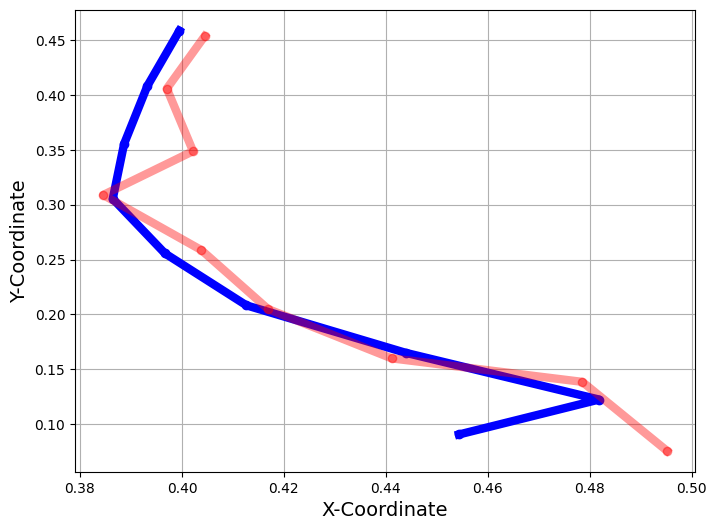

In [24]:
i = len(traj) - 1
trajectory = traj[i]
ground_truth = gr_true[i]
ee_position = ee_pos[i]

x, y = trajectory[:, 0], trajectory[:, 1]
x_g, y_g = ground_truth[:, 0], ground_truth[:, 1]
x_e, y_e = ee_position[:, 0], ee_position[:, 1]

plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', color='b', linestyle='-', linewidth=6)
plt.plot(x_g, y_g, marker='o', color='r', linestyle='-', linewidth=6, alpha=0.4)

plt.xlabel('X-Coordinate', fontsize=14)
plt.ylabel('Y-Coordinate', fontsize=14)
plt.grid(True)
plt.show()

In [25]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

def create_animation(traj, gr_true, ee_pos):
    ee_pos = ee_pos.squeeze(1)
    print("Shape of traj:", traj.shape)
    print("Shape of gr_true:", gr_true.shape)
    print("Shape of ee_pos:", ee_pos.shape)
    assert traj.ndim == 3, "traj must be 3D: (steps, markers, coordinates)"
    assert gr_true.ndim == 3, "gr_true must be 3D: (steps, markers, coordinates)"
    assert ee_pos.ndim == 2, "ee_pos must be 2D: (steps, coordinates)"

    all_pred = traj.reshape(-1, 2)
    all_true = gr_true.reshape(-1, 2)
    all_ee = ee_pos

    min_x = min(np.min(all_pred[:, 0]), np.min(all_true[:, 0]), np.min(all_ee[:, 0])) - 0.1
    max_x = max(np.max(all_pred[:, 0]), np.max(all_true[:, 0]), np.max(all_ee[:, 0])) + 0.1
    min_y = min(np.min(all_pred[:, 1]), np.min(all_true[:, 1]), np.min(all_ee[:, 1])) - 0.1
    max_y = max(np.max(all_pred[:, 1]), np.max(all_true[:, 1]), np.max(all_ee[:, 1])) + 0.1

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_title('Trajektorien Animation')
    ax.set_xlabel('X-Koordinate')
    ax.set_ylabel('Y-Koordinate')
    ax.grid(True)

    pred_line, = ax.plot([], [], 'bo-', ms=4, alpha=0.5, linewidth=2, label='Vorhersage')
    true_line, = ax.plot([], [], 'go-', ms=4, alpha=0.5, linewidth=2, label='Ground Truth')
    ee_line, = ax.plot([], [], 'rx', ms=8, label='Endeffektor')
    ax.legend()

    def init():
        pred_line.set_data([], [])
        true_line.set_data([], [])
        ee_line.set_data([], [])
        return pred_line, true_line, ee_line

    def update(frame):

        current_pred = traj[frame]
        current_true = gr_true[frame]
        current_ee = ee_pos[frame]


        pred_line.set_data(current_pred[:, 0], current_pred[:, 1])
        true_line.set_data(current_true[:, 0], current_true[:, 1])
        ee_line.set_data([current_ee[0]], [current_ee[1]])

        return pred_line, true_line, ee_line


    ani = FuncAnimation(
        fig,
        update,
        frames=traj.shape[0],
        init_func=init,
        blit=True,
        interval=50,
        repeat=False
    )

    plt.close(fig)
    return HTML(ani.to_html5_video())


animation = create_animation(traj, gr_true, ee_pos)
animation

Shape of traj: (5, 9, 2)
Shape of gr_true: (5, 9, 2)
Shape of ee_pos: (5, 2)


In [26]:
torch.save(model.state_dict(), '2D_mlp_model_20k_no_reset.pth')

In [ ]:
import time
import torch

num_warmup = 5
num_measure = 10
times = []
inputs, targets = dataset[idx]
for i in range(num_warmup + num_measure):
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start_time = time.time()
    with torch.no_grad():
        output = model(inputs)
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    end_time = time.time()

    if i >= num_warmup:
        times.append(end_time - start_time)

print(f"Mean Forward Pass Time: {sum(times)/len(times):.6f} seconds")